# Bài thực hành 4: So sánh sự tương đồng của các hình ảnh sử dụng Wavelet

## I> Mục tiêu bài tập
- Biết cách sử dụng **Wavelet Transform** để trích xuất thông tin đặc trưng.
- Làm quen với thư viện **PyWavelets**.
- Đánh giá hiệu quả của phương pháp **Hash Wavelet** (Hàm băm Wavelet) trong việc so sánh ảnh.

## II> Lý thuyết: Hash Wavelet
**Hash Wavelet** là kỹ thuật tạo mã băm (fingerprint) cho ảnh dựa trên tần số, giúp tìm kiếm ảnh tương đồng nhanh chóng.
Quy trình:
1.  **Biến đổi Wavelet (DWT)**: Phân tách ảnh thành các băng tần (xấp xỉ và chi tiết). Thường dùng băng tần thấp nhất (LL - Low-Low) để đại diện cho cấu trúc tổng quan.
2.  **Lượng tử hóa**: Chuyển các hệ số thực thành nhị phân (0 hoặc 1), thường dựa trên giá trị trung bình hoặc trung vị.
3.  **Hàm băm**: Ghép các bit lại thành chuỗi băm.
4.  **So sánh**: Dùng khoảng cách **Hamming** (đếm số bit khác nhau).


## III> Thực hành

### 1. Chuẩn bị dữ liệu và thư viện

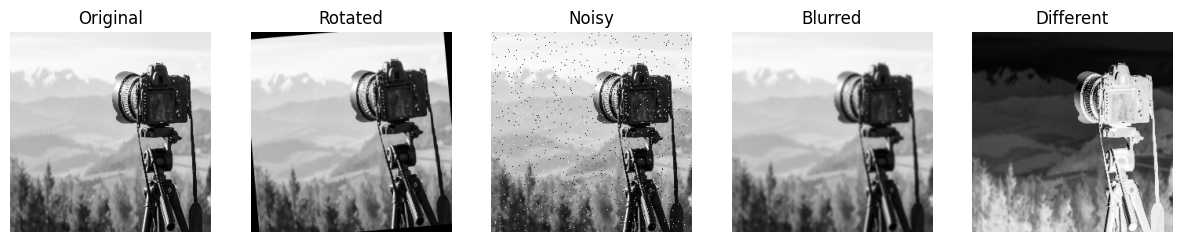

In [9]:
import pywt
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from skimage.util import random_noise

# Đường dẫn ảnh gốc
original_image_path = 'image_1.jpg'

def load_image(path, size=(256, 256)):
    if not os.path.exists(path):
        print(f"Error: {path} not found")
        return None
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    return img

# 1. Tạo dataset giả lập (Biến thể của ảnh gốc)
original_img = load_image(original_image_path)

if original_img is not None:
    # Ảnh xoay nhẹ
    rows, cols = original_img.shape
    M = cv2.getRotationMatrix2D((cols/2, rows/2), 5, 1) # Xoay 5 độ
    rotated_img = cv2.warpAffine(original_img, M, (cols, rows))

    # Ảnh nhiễu
    noisy_img = random_noise(original_img, mode='s&p', amount=0.02)
    noisy_img = (noisy_img * 255).astype(np.uint8)

    # Ảnh mờ
    blurred_img = cv2.GaussianBlur(original_img, (5, 5), 0)

    # Ảnh khác biệt hoàn toàn (đảo ngược)
    diff_img = cv2.bitwise_not(original_img)

    dataset = {
        "Original": original_img,
        "Rotated": rotated_img,
        "Noisy": noisy_img,
        "Blurred": blurred_img,
        "Different": diff_img
    }

    # Hiển thị
    plt.figure(figsize=(15, 5))
    for i, (name, img) in enumerate(dataset.items()):
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(name)
        plt.axis('off')
    plt.show()

### 2. Hàm trích xuất Hash Wavelet
Sử dụng `pywt.wavedec2` để phân tích ảnh.

In [10]:
def wavelet_hash(image, wavelet='db4', level=3):
    # Chuyển đổi sang float để tính toán
    im_float = image.astype(float)
    
    # Phân tích Wavelet
    coeffs = pywt.wavedec2(im_float, wavelet, level=level)
    
    # Lấy thành phần xấp xỉ (Approximation) ở mức thấp nhất (coeffs[0])
    LL = coeffs[0]
    
    # Lượng tử hóa: So sánh với giá trị trung vị (median)
    median_val = np.median(LL)
    
    # Tạo hash binary: 1 nếu > median, 0 nếu <= median
    hash_matrix = (LL > median_val).astype(int)
    
    # Làm phẳng thành vector
    return hash_matrix.flatten()

def hamming_distance(hash1, hash2):
    if len(hash1) != len(hash2):
        raise ValueError("Hash lengths must be equal")
    return np.sum(hash1 != hash2)

# Kiểm tra hàm
h_orig = wavelet_hash(dataset["Original"])
h_rot = wavelet_hash(dataset["Rotated"])

print(f"Hash length: {len(h_orig)} bits")
print(f"Hamming Distance (Original vs Rotated): {hamming_distance(h_orig, h_rot)}")

Hash length: 1444 bits
Hamming Distance (Original vs Rotated): 304


### 3. So sánh và đánh giá
Tính khoảng cách Hamming giữa ảnh gốc và các biến thể.

Comparing Against Original Image:
---------------------------------
Original   | Distance:    0 | Similarity: 100.00%
Rotated    | Distance:  304 | Similarity: 78.95%
Noisy      | Distance:   10 | Similarity: 99.31%
Blurred    | Distance:    2 | Similarity: 99.86%
Different  | Distance: 1444 | Similarity: 0.00%


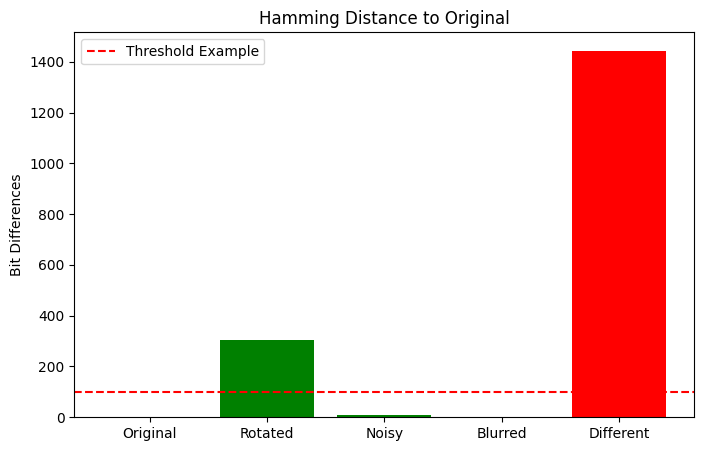

In [11]:
results = {}
base_hash = wavelet_hash(dataset["Original"])

print("Comparing Against Original Image:")
print("---------------------------------")

for name, img in dataset.items():
    h = wavelet_hash(img)
    dist = hamming_distance(base_hash, h)
    similarity = 1 - (dist / len(base_hash)) # Simple similarity metric
    results[name] = dist
    print(f"{name:10} | Distance: {dist:4} | Similarity: {similarity:.2%}")

plt.figure(figsize=(8, 5))
models = list(results.keys())
dists = list(results.values())
plt.bar(models, dists, color=['blue', 'green', 'green', 'green', 'red'])
plt.title('Hamming Distance to Original')
plt.ylabel('Bit Differences')
plt.axhline(y=100, color='r', linestyle='--', label='Threshold Example')
plt.legend()
plt.show()

### 4. Đánh giá (ROC Curve - Demo)
Trong thực tế, ta cần tập dữ liệu lớn hơn. Ở đây ta minh họa khái niệm.

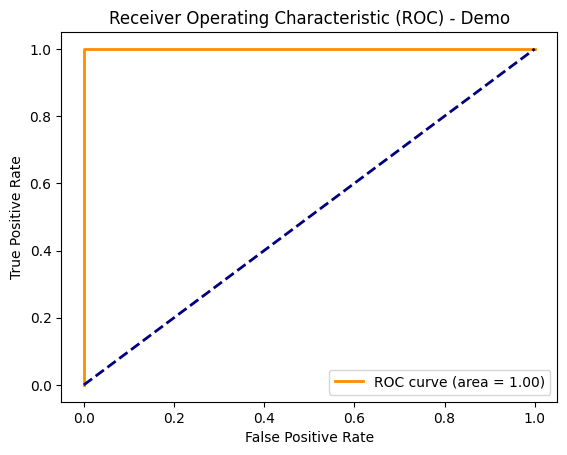

In [12]:
from sklearn.metrics import roc_curve, auc

# Giả lập nhãn và điểm số (Khoảng cách nghịch đảo)
# 1: Similar (Rotated, Noisy, Blurred), 0: Diff (Different)
# Ta thêm chính nó (Original) vào nhóm Similar
y_true = np.array([1, 1, 1, 1, 0]) # Original, Rotated, Noisy, Blurred, Different

# Score càng cao càng giống -> Score = max_dist - dist
# Giả sử max_dist có thể là len(hash)
max_possible_dist = len(base_hash)
y_scores = np.array([
    max_possible_dist - results["Original"],
    max_possible_dist - results["Rotated"],
    max_possible_dist - results["Noisy"],
    max_possible_dist - results["Blurred"],
    max_possible_dist - results["Different"]
])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Demo')
plt.legend(loc="lower right")
plt.show()



### 5. Tính toán các chỉ số đánh giá cụ thể (Accuracy, Recall, Precision)

In [13]:

from sklearn.metrics import accuracy_score, recall_score, precision_score

# Chọn ngưỡng (threshold) tối ưu từ ROC (Youden's J statistic)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Tạo nhãn dự đoán dựa trên ngưỡng
y_pred = (y_scores >= optimal_threshold).astype(int)

accuracy = accuracy_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)

print(f"Optimal Threshold: {optimal_threshold}")
print("Độ chính xác (Accuracy):", accuracy)
print("Độ nhạy (Recall):", recall)
print("Độ chính xác (Precision):", precision)


Optimal Threshold: 1140.0
Độ chính xác (Accuracy): 1.0
Độ nhạy (Recall): 1.0
Độ chính xác (Precision): 1.0


## IV> Kết luận
- **Hash Wavelet** trích xuất đặc trưng tần số thấp, rất bền vững với các biến đổi nhiễu, mờ, và thay đổi độ sáng.
- Với biến đổi xoay (Rotation), Hash Wavelet tiêu chuẩn kém hiệu quả hơn (khoảng cách tăng nhanh), cần các kỹ thuật bất biến xoay (Rotation Invariant) nâng cao hơn hoặc tiền xử lý xoay.
- Khoảng cách Hamming cung cấp một thước đo đơn giản và hiệu quả để so sánh.